In [8]:
# from google.colab import drive

# drive.mount("/content/drive/", force_remount=True)
# Google Drive\Proyecto_1

Mounted at /content/drive/


In [ ]:
#import warnings
#warnings.filterwarnings('ignore')
#from google.colab import files

# El siguiente archivo solicitado es para habilitar la API de Kaggle en el entorno que está trabajando.
# Este archivo se descarga entrando a su perfíl de Kaggle, en la sección API, presionando donde dice: Create New API Token

#uploaded = files.upload()

#for fn in uploaded.keys():
    #print('User uploaded file "{name}" with length {length} bytes'.format(
      #name=fn, length=len(uploaded[fn])))

#Then move kaggle.json into the folder where the API expects to find it.
#!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download --c higgs-boson 


  0%|          | 0.00/54.3M [00:00<?, ?B/s]
  2%|1         | 1.00M/54.3M [00:00<00:44, 1.26MB/s]
  4%|3         | 2.00M/54.3M [00:00<00:21, 2.54MB/s]
  7%|7         | 4.00M/54.3M [00:01<00:09, 5.43MB/s]
 15%|#4        | 8.00M/54.3M [00:01<00:04, 11.6MB/s]
 22%|##2       | 12.0M/54.3M [00:01<00:02, 16.5MB/s]
 28%|##7       | 15.0M/54.3M [00:01<00:02, 19.1MB/s]
 33%|###3      | 18.0M/54.3M [00:01<00:01, 21.6MB/s]
 41%|####      | 22.0M/54.3M [00:01<00:01, 24.7MB/s]
 46%|####6     | 25.0M/54.3M [00:01<00:01, 25.0MB/s]
 52%|#####1    | 28.0M/54.3M [00:01<00:01, 25.5MB/s]
 57%|#####7    | 31.0M/54.3M [00:02<00:00, 25.2MB/s]
 63%|######2   | 34.0M/54.3M [00:02<00:00, 25.2MB/s]
 68%|######8   | 37.0M/54.3M [00:02<00:00, 25.2MB/s]
 76%|#######5  | 41.0M/54.3M [00:02<00:00, 27.5MB/s]
 81%|########1 | 44.0M/54.3M [00:02<00:00, 28.2MB/s]
 88%|########8 | 48.0M/54.3M [00:02<00:00, 29.3MB/s]
 96%|#########5| 52.0M/54.3M [00:02<00:00, 30.2MB/s]
100%|##########| 54.3M/54.3M [00:02<00:00, 19.8MB/s]


In [6]:
#!unzip higgs-boson.zip

In [7]:
#!unzip training.zip
#!unzip test.zip

In [8]:
import shutil
shutil.unpack_archive('./higgs-boson.zip', './')

In [9]:
shutil.unpack_archive('./training.zip', './')
shutil.unpack_archive('./test.zip', './')
shutil.unpack_archive('./random_submission.zip', './')

In [48]:
import os
import csv
import math
import numpy as np
import pandas as pd
#!pip install shap
import shap
from comet_ml import Experiment

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

## Carga y visualización inicial de datos

In [5]:
df_train = pd.read_csv('training.csv')
df_test = pd.read_csv('test.csv')

In [6]:
df_train.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


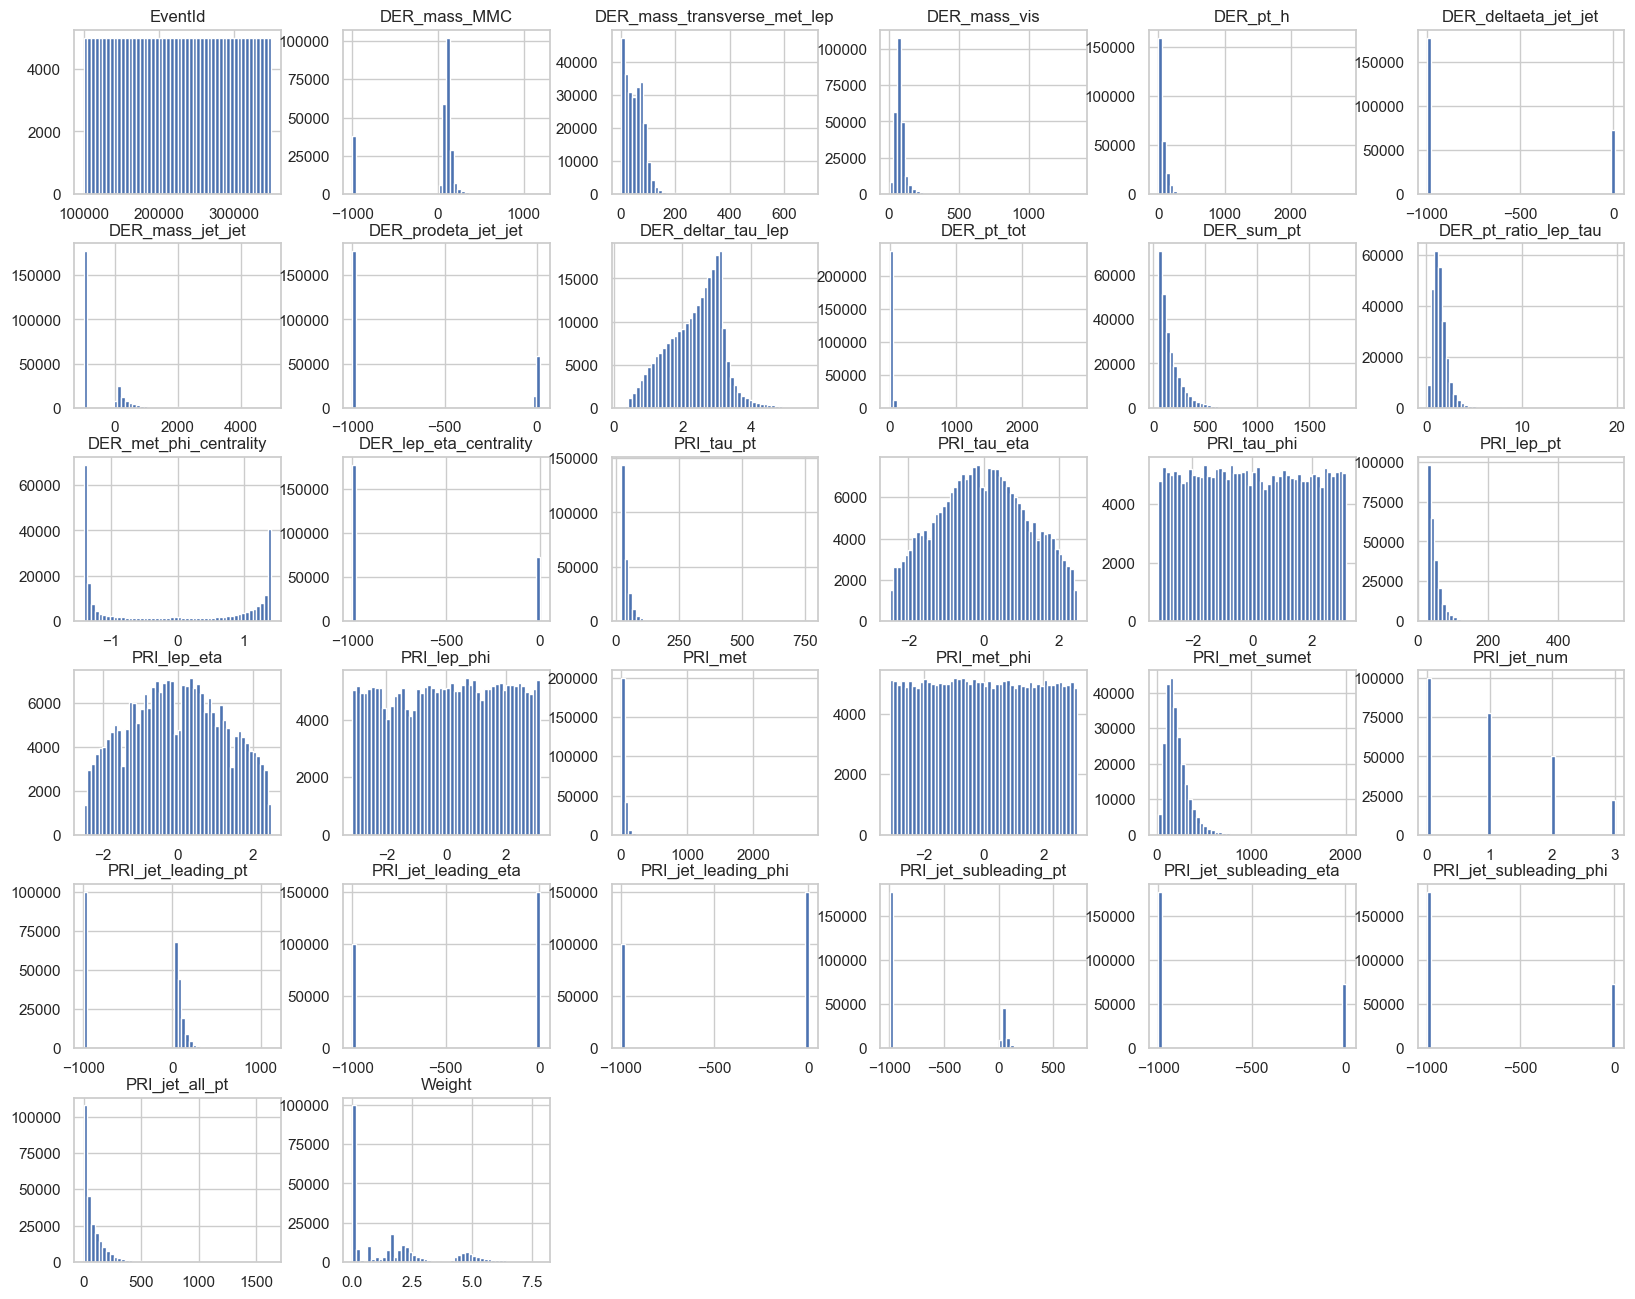

In [7]:
df_train.hist(bins=50, figsize=(20, 16))
plt.show()

In [8]:
#df_train['Label'] = (df_train['Label'] == 's').astype(int)
# Las variables ”EventId”, ”Weight” y ”Label” no deben ser usados como datos de entrada para el entrenamiento o clasificación.
X = df_train.drop(['EventId','Label','Weight'], axis=1)
y = df_train['Label']
Weights = df_train['Weight']
imputer = SimpleImputer(missing_values=-999.00, strategy='most_frequent')
feature_names = X.columns
X = imputer.fit_transform(X)
X = pd.DataFrame(data=X, columns=feature_names)
X.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,197.760,...,-0.277,258.733,2.0,67.435,2.150,0.444,46.062,1.240,-2.475,113.497
1,160.937,68.768,103.235,48.146,0.326,161.729,0.000,3.473,2.078,125.157,...,-1.916,164.546,1.0,46.226,0.725,1.158,30.447,-1.699,-2.135,46.226
2,96.415,162.172,125.953,35.635,0.326,161.729,0.000,3.148,9.336,197.814,...,-2.186,260.414,1.0,44.251,2.053,-2.028,30.447,-1.699,-2.135,44.251
3,143.905,81.417,80.943,0.414,0.326,161.729,0.000,3.310,0.414,75.968,...,0.060,86.062,0.0,30.363,-1.507,-0.157,30.447,-1.699,-2.135,-0.000
4,175.864,16.915,134.805,16.405,0.326,161.729,0.000,3.891,16.405,57.983,...,-0.871,53.131,0.0,30.363,-1.507,-0.157,30.447,-1.699,-2.135,0.000


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   EventId                      250000 non-null  int64  
 1   DER_mass_MMC                 250000 non-null  float64
 2   DER_mass_transverse_met_lep  250000 non-null  float64
 3   DER_mass_vis                 250000 non-null  float64
 4   DER_pt_h                     250000 non-null  float64
 5   DER_deltaeta_jet_jet         250000 non-null  float64
 6   DER_mass_jet_jet             250000 non-null  float64
 7   DER_prodeta_jet_jet          250000 non-null  float64
 8   DER_deltar_tau_lep           250000 non-null  float64
 9   DER_pt_tot                   250000 non-null  float64
 10  DER_sum_pt                   250000 non-null  float64
 11  DER_pt_ratio_lep_tau         250000 non-null  float64
 12  DER_met_phi_centrality       250000 non-null  float64
 13 

In [10]:
X.describe()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,117.979510,49.239819,81.181982,57.895962,0.928901,222.680894,-0.238431,2.373100,18.917332,158.432217,...,-0.010119,209.797178,0.979176,63.057414,-0.604241,-0.070185,38.349102,-1.209435,-1.515942,73.064591
std,53.536914,35.344886,40.828691,63.655682,1.330394,234.483790,1.966484,0.782911,22.273494,115.706115,...,1.812223,126.499506,0.977426,54.044504,1.566651,1.406832,21.204255,1.335707,1.376742,98.015662
min,9.044000,0.000000,6.329000,0.000000,0.000000,13.602000,-18.066000,0.208000,0.000000,46.104000,...,-3.142000,13.678000,0.000000,30.000000,-4.499000,-3.142000,30.000000,-4.500000,-3.142000,0.000000
25%,95.665000,19.241000,59.388750,14.068750,0.326000,161.729000,0.000000,1.810000,2.841000,77.550000,...,-1.575000,123.017500,0.000000,30.363000,-1.507000,-0.556000,30.447000,-1.699000,-2.135000,-0.000000
50%,105.012000,46.524000,73.752000,38.467500,0.326000,161.729000,0.000000,2.491500,12.315500,120.664500,...,-0.024000,179.739000,1.000000,38.960000,-1.507000,-0.157000,30.447000,-1.699000,-2.135000,40.512500
75%,130.606250,73.598000,92.259000,79.169000,0.490000,161.729000,0.000000,2.961000,27.591000,200.478250,...,1.561000,263.379250,2.000000,75.349000,0.433000,0.503000,33.703000,-1.699000,-2.135000,109.933750
max,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,1852.462000,...,3.142000,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000


In [17]:
#ver y plotear distribución de los datos que tienen faltantes para ver con que los llenamos (media, mediana, más frecuente etc..)

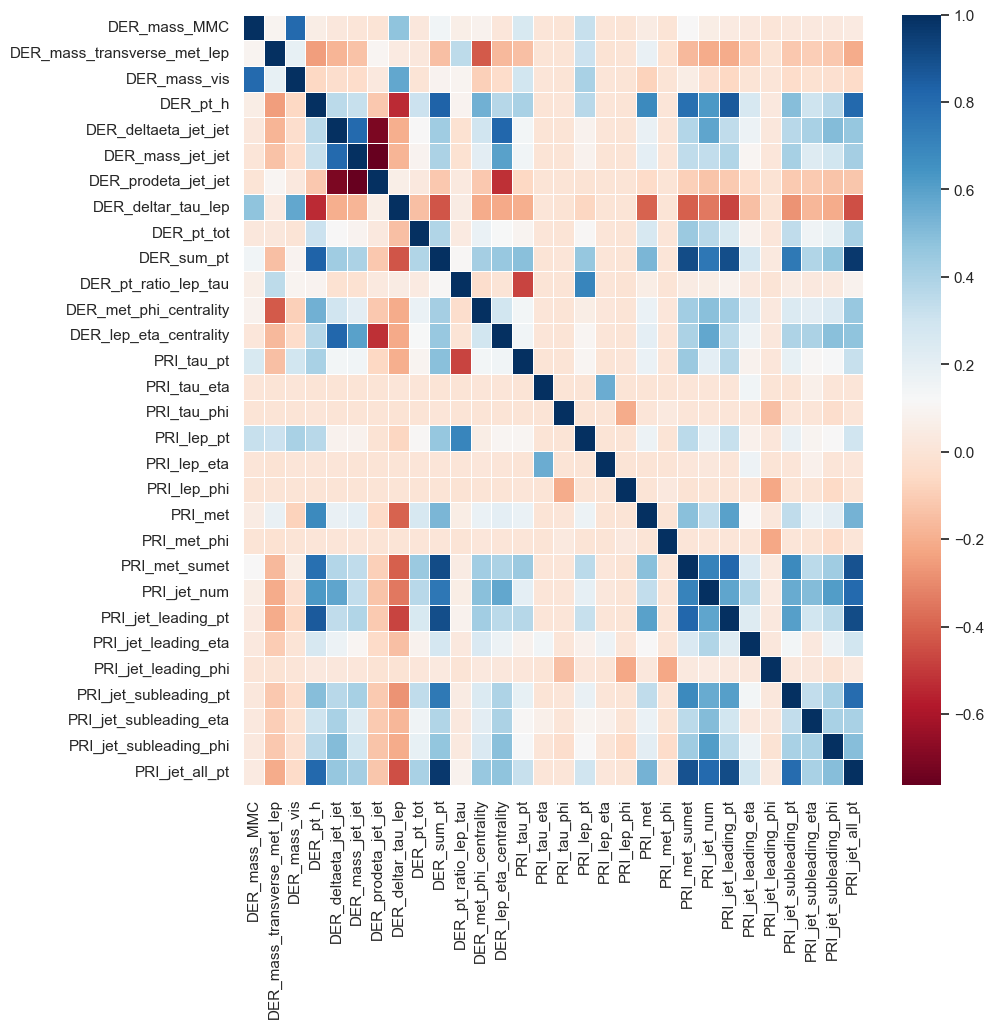

In [11]:
#Matriz de correlación
df_numeric = X.select_dtypes(include=[np.number])
corr_matrix = df_numeric.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, linewidth=0.5,annot=False,cmap="RdBu", fmt=".2f");

## s y b

In [12]:
n_s = (df_train['Label'] == 's').sum()
n_b = (df_train['Label'] == 'b').sum()

print(f"Valor esperado de signal: {n_s} \nValor esperado de background: {n_b}")

Valor esperado de signal: 85667 
Valor esperado de background: 164333


In [13]:
n_s_weights = df_train.loc[df_train['Label'] == 's']['Weight'].sum()
n_b_weights = df_train.loc[df_train['Label'] == 'b']['Weight'].sum()

print(f"Suma de pesos de signal: {n_s_weights} \nSuma de pesos de background: {n_b_weights}")

Suma de pesos de signal: 691.9886077125524 
Suma de pesos de background: 410999.8473218613


## IterativeImputer

In [14]:
df_train = pd.read_csv('training.csv')
df_iter = df_train.copy()
df_iter = df_iter.drop(['EventId','Label','Weight'], axis=1)
feature_names = df_iter.columns
iterative = IterativeImputer(missing_values=-999, max_iter=30, tol=1e-3, random_state=42)
X_train_iterative = iterative.fit_transform(df_iter)

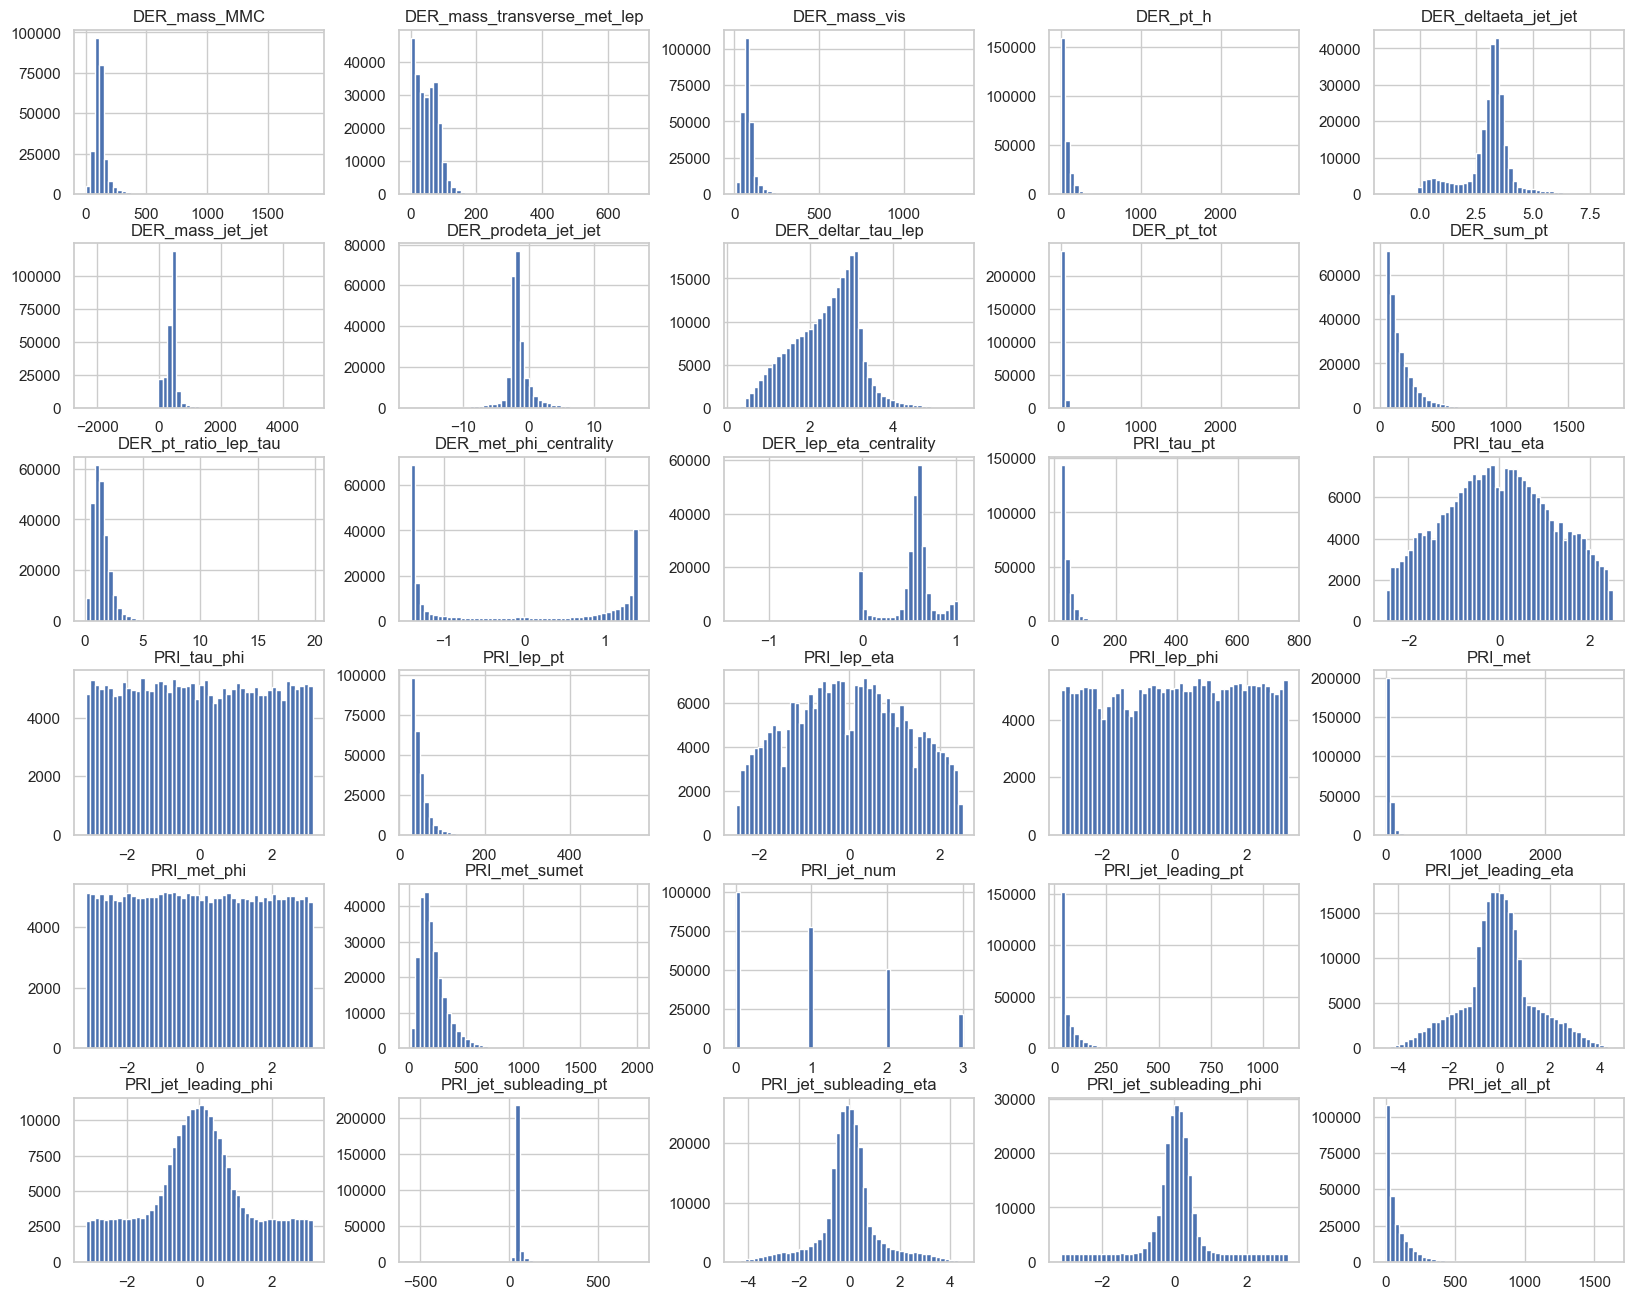

In [15]:
X_train_iterative = pd.DataFrame(data=X_train_iterative, columns=feature_names)
X_train_iterative.hist(bins=50, figsize=(20, 16))
plt.show()

## Escalado (no usamos)

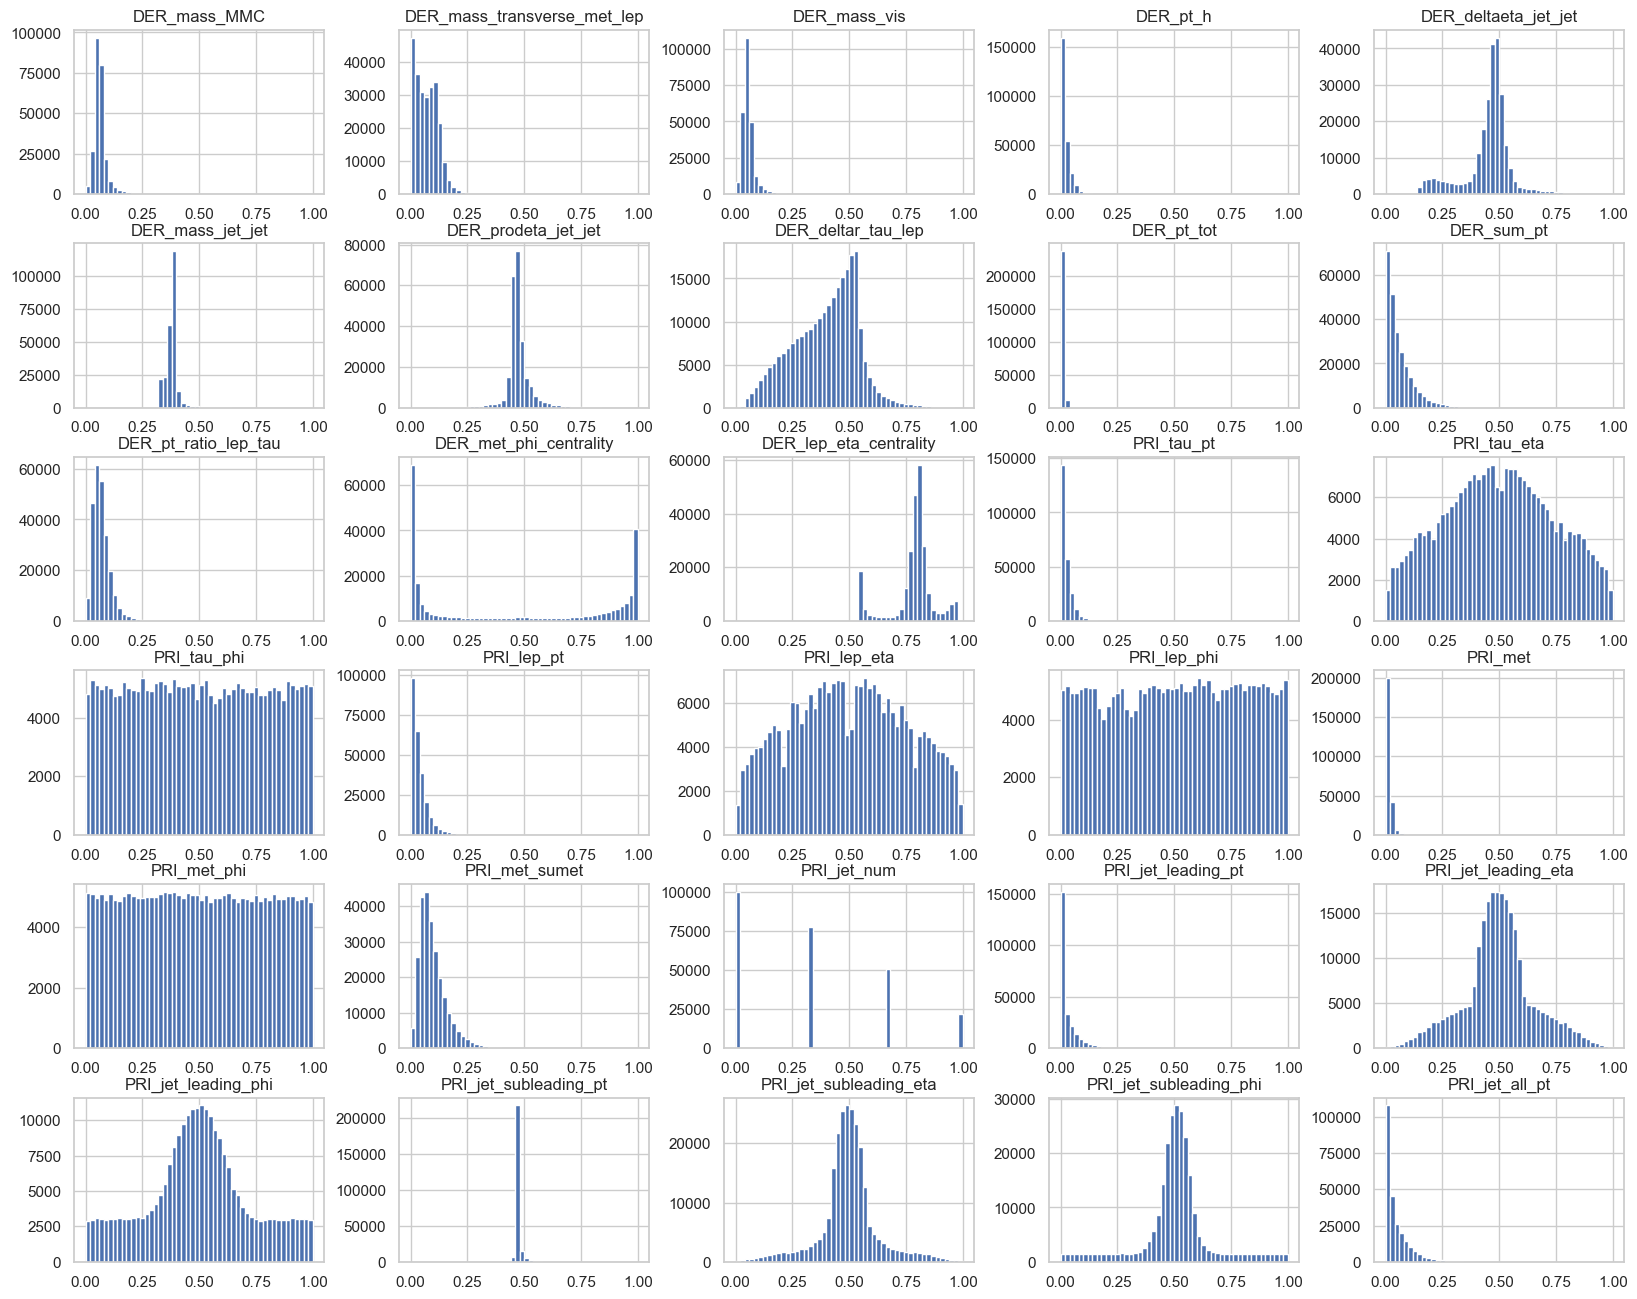

In [38]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_iterative)
X_train_scaled = pd.DataFrame(data=X_train_scaled, columns=feature_names)
X_train_scaled.hist(bins=50, figsize=(20, 16))
plt.show()

## Transformación logarítmica

In [16]:
log_cols = [
    'DER_mass_MMC',
    'DER_mass_transverse_met_lep',
    'DER_mass_vis',
    'DER_pt_h',
    'DER_pt_tot',
    'DER_sum_pt',
    'DER_pt_ratio_lep_tau',
    'PRI_met_sumet',
    'PRI_jet_leading_pt',
    'PRI_jet_subleading_pt',
    'PRI_jet_all_pt',
    'PRI_lep_pt',
    'PRI_tau_pt',
    'PRI_met'
]

In [17]:
def safe_log1p(x):
    x = np.where(x <= -1, 0, x)
    return np.log1p(x)

X_train_log = X_train_iterative.copy()
for col in log_cols:
    X_train_log[col] = safe_log1p(X_train_log[col])  # log1p es log(1 + x), para evitar log(0)
y_train = (df_train['Label'] == 's').astype(int)

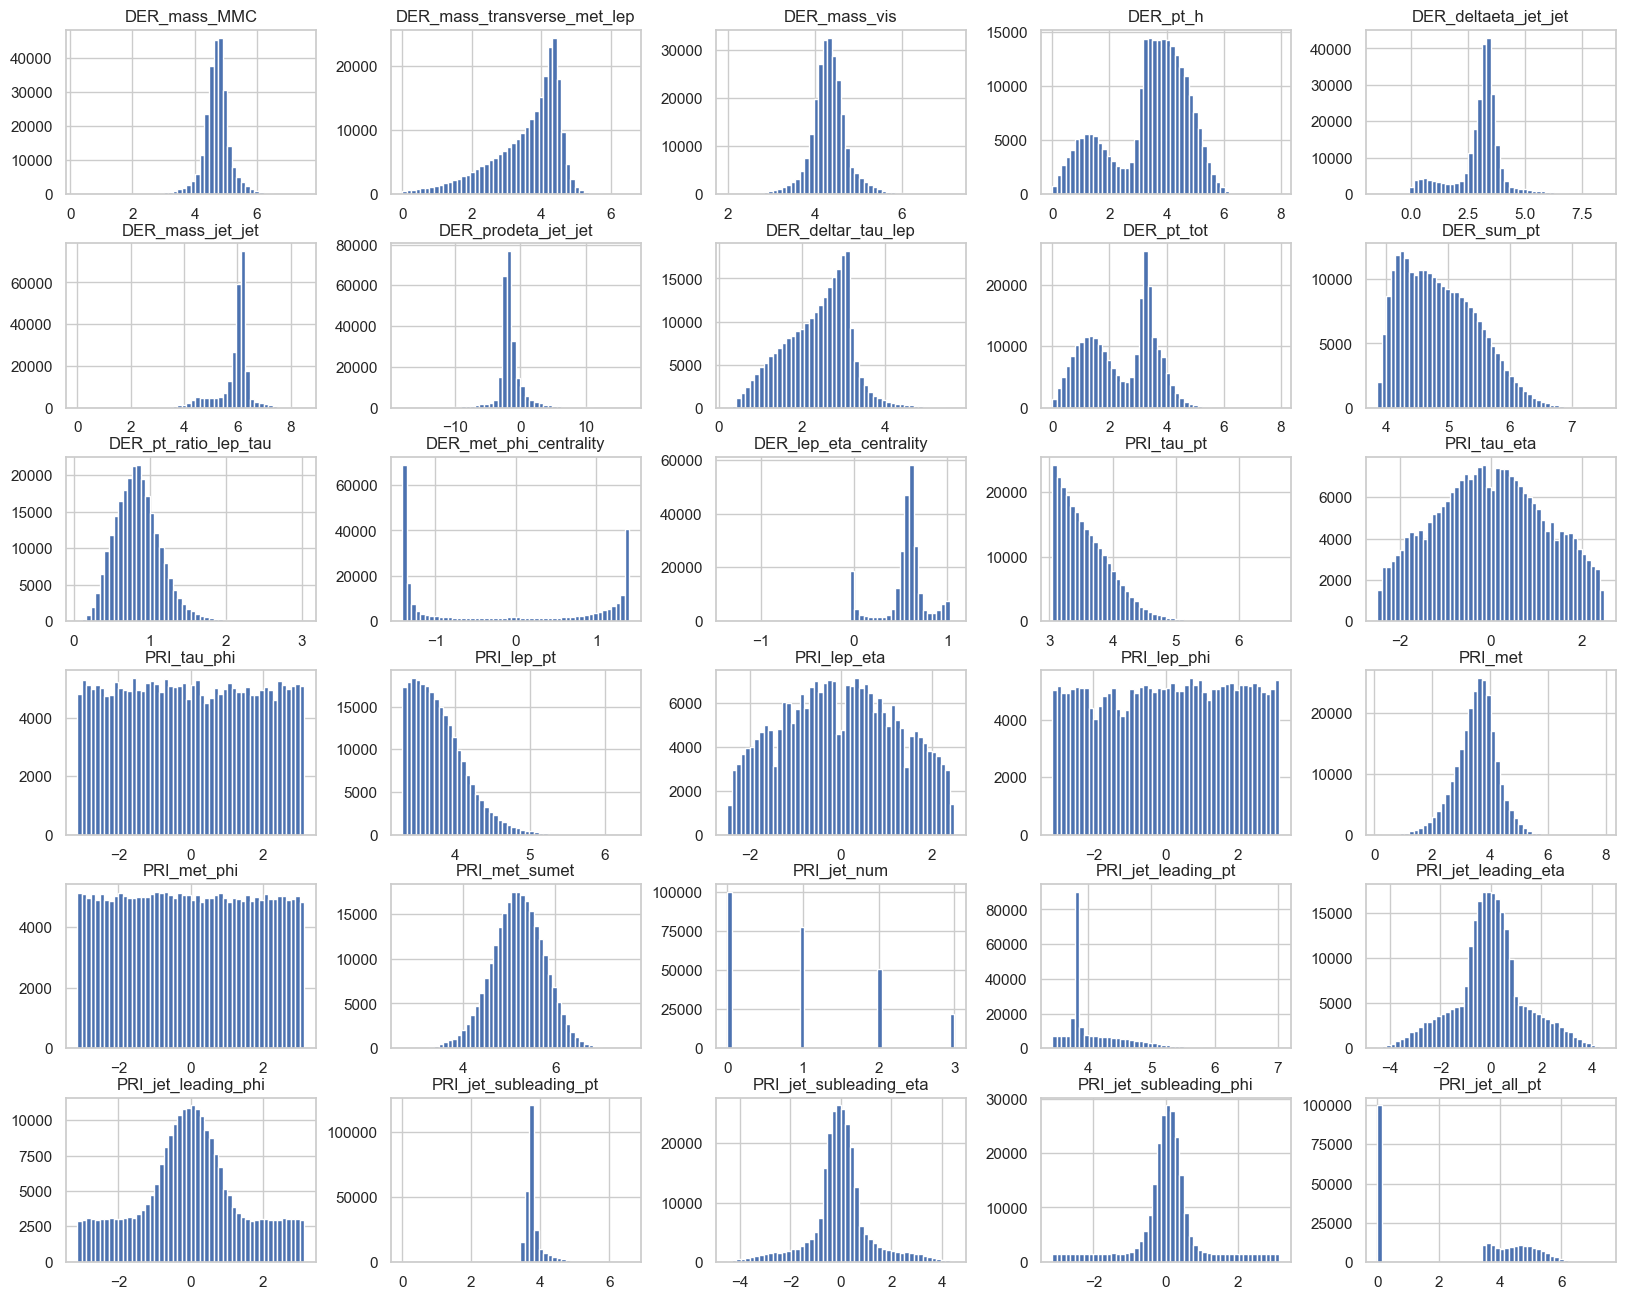

In [98]:
X_train_log.hist(bins=50, figsize=(20, 16))
plt.show()

## PCA (no usamos)

In [ ]:
preprocessing_pipeline = Pipeline(steps=[
    ('impute', IterativeImputer(missing_values=-999, max_iter=30, tol=1e-3, random_state=42)),
    ('scaler', StandardScaler())
])

X_train_preprocessed = preprocessing_pipeline.fit_transform(X)

pca = PCA().fit(X_train_preprocessed)
varianza_explicada = np.cumsum(pca.explained_variance_ratio_)
n_cps = np.argmax(varianza_explicada >= 0.99) + 1

plt.figure(figsize=(10, 6))
plt.plot(varianza_explicada, linewidth=2)
plt.axis('tight')
plt.grid(True)
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulativa')
plt.title('Varianza explicada por los componentes principales')
plt.axhline(y=0.99, color='r', linestyle='--', label='99% de varianza explicada')
plt.axvline(x=n_cps, color='r', linestyle='--', label=f'Número de CPs para 99% varianza: {n_cps}')
plt.legend()
plt.show()

## Stratified Shuffle Split

<Axes: >

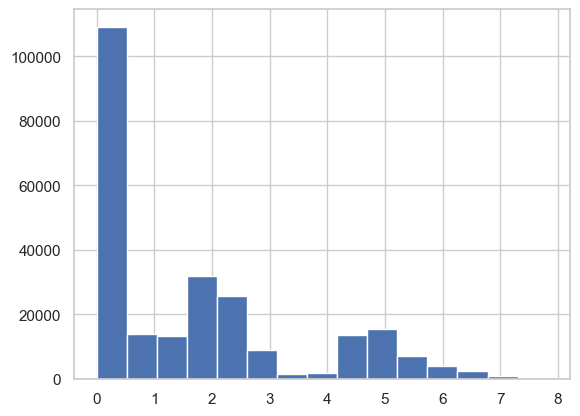

In [18]:
df_train['Weight'].hist(bins=15)

In [19]:
Weights_bins = pd.cut(df_train['Weight'],
                               bins=[0, 1, 2, 3, 4, 5, 6, 7, np.inf],
                               labels=[1, 2, 3, 4, 5, 6, 7, 8])

test_size = 0.2
escalado_pesos = 1/test_size

splitter = StratifiedShuffleSplit(n_splits=5, test_size=test_size, random_state=42)
stratified_indices = []



for train_index, val_index in splitter.split(df_train, Weights_bins):
    stratified_indices.append((train_index, val_index))

## AMS

In [20]:
def AMS(s, b):
    """ Approximate Median Significance defined as:
        AMS = sqrt(
                2 { (s + b + b_r) log[1 + (s/(b+b_r))] - s}
              )
    where b_r = 10, b = background, s = signal, log is natural logarithm """

    br = 10
    radicand = 2*((s+b+br)*math.log(1.0 + s/(b+br))-s)

    if radicand < 0:
        #print('radicand is negative. Exiting')
        raise ValueError('radicand is negative. Exiting')
        #exit()
    else:
        return math.sqrt(radicand)

def AMS_2(y_true, y_pred):
    signal = np.sum(escalado_pesos*Weights.iloc[y_true.index][np.logical_and(y_pred == 1, y_true == 1)])
    background = np.sum(escalado_pesos*Weights.iloc[y_true.index][np.logical_and(y_pred == 1, y_true == 0)])
    return AMS(signal, background)

In [21]:
AMS_scorer = make_scorer(AMS_2, greater_is_better=True)

## Random Forest

In [ ]:
param_bayes_rf = {
    'n_estimators': Integer(10, 500),
    'max_depth': Integer(10, 40),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 8),
    'max_features': Real(0.1, 1.0, "uniform")
}

rf_base = RandomForestClassifier(random_state=42)

bayes_search_rf = BayesSearchCV(
    estimator=rf_base,
    search_spaces=param_bayes_rf,
    n_iter=10,
    cv=stratified_indices,
    scoring=AMS_scorer,
    n_jobs=-1,
    verbose=0,
    random_state=42
)

bayes_search_rf.fit(X_train, y_train)

print("Mejor score RandomForest Bayesiano:", bayes_search_rf.best_score_)
print("Mejores parámetros RandomForest Bayesiano:", bayes_search_rf.best_params_)

## XGBClassifier

In [79]:
param_bayes_xgb = {
    'n_estimators': Integer(10, 500),
    'max_depth': Integer(10, 100),
    'learning_rate': Real(0.0001, 1),
    'min_child_weight': Integer(10, 30),
    'subsample': Real(0.1, 1.0),
    'colsample_bytree': Real(0.1, 1.0),
    'gamma': Real(0, 5),
    'reg_alpha': Real(0, 1),  # L1 regularization
    'reg_lambda': Real(1, 5)  # L2 regularization
}

xgb_base = XGBClassifier(
    #objective='binary:hinge',
    random_state=42,
    tree_method='hist',  # Método de árbol compatible con la GPU
    device='cuda'        # Configuración para usar la GPU
)

bayes_search_xgb = BayesSearchCV(
    estimator=xgb_base,
    search_spaces=param_bayes_xgb,
    n_iter=200,
    cv=stratified_indices,
    scoring=AMS_scorer,
    n_jobs=1, # Tiene que ser 1 cuando se usa GPU
    verbose=3,
    random_state=42
)

bayes_search_xgb.fit(X_train_log, y_train)
best_model_xgb = bayes_search_xgb.best_estimator_
print("Mejor score XGB Bayesiano:", bayes_search_xgb.best_score_)
print("Mejores parámetros XGB Bayesiano:", bayes_search_xgb.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Mejor score XGB Bayesiano: 3.2397647944683863
Mejores parámetros XGB Bayesiano: OrderedDict([('colsample_bytree', 0.4893204993147078), ('gamma', 0.0), ('learning_rate', 0.07447096918037242), ('max_depth', 69), ('min_child_weight', 18), ('n_estimators', 10), ('reg_alpha', 0.14077367912659144), ('reg_lambda', 3.0393252974841176), ('subsample', 0.7356246713487878)])


## Pipelines

### Modelo 1

In [27]:
#Con los pesos reescalados
#Mejor score XGB Bayesiano: 2.911132579266947
#Mejores parámetros XGB Bayesiano: OrderedDict([('colsample_bytree', 0.44867064365013964), ('gamma', 5.0), ('learning_rate', 0.11236255184697409), ('max_depth', 58), ('min_child_weight', 30), ('n_estimators', 321), ('reg_alpha', 1.0), ('reg_lambda', 1.4753054372446621), ('subsample', 1.0)])

best_learning_rate = 0.11236255184697409
best_max_depth = 58
best_n_estimators = 321
best_min_child_weight = 30
best_subsample = 1.0
best_colsample_bytree = 0.44867064365013964
best_gamma = 5.0
best_reg_alpha = 1.0
best_reg_lambda = 1.4753054372446621


df_train = pd.read_csv('training.csv')

X_train = df_train.drop(['EventId', 'Label', 'Weight'], axis=1)
y_train = (df_train['Label'] == 's').astype(int)


pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=-999.00, strategy='most_frequent')),
    #('scaler', StandardScaler()),
    #('pca', PCA(n_components=25)),
    ('regressor', XGBClassifier(random_state=42,
                                learning_rate=best_learning_rate,
                                max_depth=best_max_depth,
                                n_estimators=best_n_estimators,
                                min_child_weight=best_min_child_weight,
                                subsample=best_subsample,
                                colsample_bytree=best_colsample_bytree,
                                gamma=best_gamma,
                                reg_alpha=best_reg_alpha,
                                reg_lambda=best_reg_lambda))
])


pipeline.fit(X_train, y_train)

df_test = pd.read_csv('test.csv')
EventId_test = df_test['EventId']
X_test = df_test.drop(['EventId'], axis=1)
y_pred = pipeline.predict(X_test)

### Modelo 2

In [ ]:
#Utilizando 'binary:hinge' y expandiendo la grilla de parámetros
#Mejor score XGB Bayesiano: 3.121321749263527
#Mejores parámetros XGB Bayesiano: OrderedDict([('colsample_bytree', 0.1), ('gamma', 3.3268083167830147), ('learning_rate', 0.05032094012710089), ('max_depth', 61), ('min_child_weight', 30), ('n_estimators', 101), ('reg_alpha', 0.9362065516425802), ('reg_lambda', 3.9935074562478534), ('subsample', 0.9940517589435298)])

best_learning_rate = 0.05032094012710089
best_max_depth = 61
best_n_estimators = 101
best_min_child_weight = 30
best_subsample = 0.9940517589435298
best_colsample_bytree = 0.1
best_gamma = 3.3268083167830147
best_reg_alpha = 0.9362065516425802
best_reg_lambda = 3.9935074562478534


df_train = pd.read_csv('training.csv')

X_train = df_train.drop(['EventId', 'Label', 'Weight'], axis=1)
y_train = (df_train['Label'] == 's').astype(int)


pipeline_2 = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=-999.00, strategy='most_frequent')),
    ('regressor', XGBClassifier(random_state=42,
                                objective='binary:hinge', #minimiza directamente el error de clasificación
                                learning_rate=best_learning_rate,
                                max_depth=best_max_depth,
                                n_estimators=best_n_estimators,
                                min_child_weight=best_min_child_weight,
                                subsample=best_subsample,
                                colsample_bytree=best_colsample_bytree,
                                gamma=best_gamma,
                                reg_alpha=best_reg_alpha,
                                reg_lambda=best_reg_lambda))
])


pipeline_2.fit(X_train, y_train)

df_test = pd.read_csv('test.csv')
EventId_test = df_test['EventId']
X_test = df_test.drop(['EventId'], axis=1)
y_pred = pipeline.predict(X_test)

### Modelo 3 Transformación Logarítmica

In [ ]:
log_cols = [
    'DER_mass_MMC',
    'DER_mass_transverse_met_lep',
    'DER_mass_vis',
    'DER_pt_h',
    'DER_mass_jet_jet',
    'DER_pt_tot',
    'DER_sum_pt',
    'DER_pt_ratio_lep_tau',
    'PRI_met_sumet',
    'PRI_jet_leading_pt',
    'PRI_jet_subleading_pt',
    'PRI_jet_all_pt',
    'PRI_lep_pt',
    'PRI_tau_pt',
    'PRI_met'
]

In [27]:
#Aplicando transformación logarítmica a las características con sesgo considerable hacia valores bajos con largas colas hacia valores altos
# y expandiendo el rango

#Mejor score XGB Bayesiano: 3.374894067465219
#Mejores parámetros XGB Bayesiano: OrderedDict([('colsample_bytree', 0.18046626753049858), ('gamma', 2.1773275883676475), ('learning_rate', 0.0001), ('max_depth', 58), ('min_child_weight', 10), ('n_estimators', 254), ('reg_alpha', 0.8928946965038408), ('reg_lambda', 1.0), ('subsample', 1.0)])

best_learning_rate = 0.0001
best_max_depth = 58
best_n_estimators = 254
best_min_child_weight = 10
best_subsample = 1.0
best_colsample_bytree = 0.18046626753049858
best_gamma = 2.1773275883676475
best_reg_alpha = 0.8928946965038408
best_reg_lambda = 1.0

log_cols = ['DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_sum_pt',
            'DER_pt_ratio_lep_tau', 'PRI_met_sumet', 'PRI_jet_leading_pt', 'PRI_jet_subleading_pt',
            'PRI_jet_all_pt', 'PRI_lep_pt', 'PRI_tau_pt', 'PRI_met']

df_train = pd.read_csv('training.csv')
X_train = df_train.drop(['EventId', 'Label', 'Weight'], axis=1)
y_train = (df_train['Label'] == 's').astype(int)

df_test = pd.read_csv('test.csv')
EventId_test = df_test['EventId']
X_test = df_test.drop(['EventId'], axis=1)

# imputer = SimpleImputer(missing_values=-999.00, strategy='most_frequent')

# feature_names = X_train.columns
# X_train = imputer.fit_transform(X_train)
# X_train = pd.DataFrame(data=X_train, columns=feature_names)

# feature_names = X_test.columns
# X_test = imputer.fit_transform(X_test)
# X_test = pd.DataFrame(data=X_test, columns=feature_names)

# for col in log_cols:
#     X_train[col] = np.log1p(X_train[col])  # log1p es log(1 + x), para evitar log(0)

# for col in log_cols:
#     X_test[col] = np.log1p(X_test[col])  # log1p es log(1 + x), para evitar log(0)


preprocessing = ColumnTransformer([
    ('impute', SimpleImputer(missing_values=-999.00, strategy='most_frequent'), X_train.columns),
    ('log', FunctionTransformer(np.log1p), log_cols)
], remainder='passthrough')

pipeline_3 = Pipeline([
    ('preprocesamiento', preprocessing),
    ('regressor', XGBClassifier(random_state=42,
                                #tree_method='hist',  # Método de árbol compatible con la GPU
                                #device='cuda',        # Configuración para usar la GPU
                                learning_rate=best_learning_rate,
                                max_depth=best_max_depth,
                                n_estimators=best_n_estimators,
                                min_child_weight=best_min_child_weight,
                                subsample=best_subsample,
                                colsample_bytree=best_colsample_bytree,
                                gamma=best_gamma,
                                reg_alpha=best_reg_alpha,
                                reg_lambda=best_reg_lambda))
])



pipeline_3.fit(X_train, y_train)
y_pred = pipeline_3.predict(X_test)

C:\Users\Guillermo\anaconda3\envs\TAA-py311\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
C:\Users\Guillermo\anaconda3\envs\TAA-py311\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


### Modelo 4 IterativeImputer

In [65]:
## Haciendo IterativeImputer en vez de SimpleImputer

#Mejor score XGB Bayesiano: 3.337863730645794
#Mejores parámetros XGB Bayesiano: OrderedDict([('colsample_bytree', 0.5684302560541605), ('gamma', 0.0), ('learning_rate', 0.056715840402300946), ('max_depth', 100), ('min_child_weight', 30), ('n_estimators', 10), ('reg_alpha', 0.6228914760699901), ('reg_lambda', 1.0), ('subsample', 1.0)])

best_learning_rate = 0.056715840402300946
best_max_depth = 100
best_n_estimators = 10
best_min_child_weight = 30
best_subsample = 1.0
best_colsample_bytree = 0.5684302560541605
best_gamma = 0.0
best_reg_alpha = 0.6228914760699901
best_reg_lambda = 1.0


df_train = pd.read_csv('training.csv')

X_train = df_train.drop(['EventId', 'Label', 'Weight'], axis=1)
y_train = (df_train['Label'] == 's').astype(int)


pipeline_4 = Pipeline(steps=[
    ('impute', IterativeImputer(missing_values=-999, max_iter=30, tol=1e-3, random_state=42)),
    ('regressor', XGBClassifier(random_state=42,
                                learning_rate=best_learning_rate,
                                max_depth=best_max_depth,
                                n_estimators=best_n_estimators,
                                min_child_weight=best_min_child_weight,
                                subsample=best_subsample,
                                colsample_bytree=best_colsample_bytree,
                                gamma=best_gamma,
                                reg_alpha=best_reg_alpha,
                                reg_lambda=best_reg_lambda))
])

pipeline_4.fit(X_train, y_train)

df_test = pd.read_csv('test.csv')
X_test = df_test.drop(['EventId'], axis=1)
y_pred = pipeline_4.predict(X_test)

In [62]:
from sklearn.metrics import precision_score, recall_score


th = np.linspace(0, 1, 100)

AMS_threshold_avg = np.array([0]*len(th))

for i in range(5):
    pipeline_4.fit(X_train.iloc[stratified_indices[i][0]], y_train.iloc[stratified_indices[i][0]])
    y_pred_proba = pipeline_4.predict_proba(X_train.iloc[stratified_indices[i][1]])

    AMS_threshold = []
    for t in th:
        y_pred = (y_pred_proba[:, 1] > t).astype(int)
        AMS_threshold.append(AMS_2(y_train.iloc[stratified_indices[i][1]], y_pred))
        
    AMS_threshold_avg = np.add(AMS_threshold_avg, AMS_threshold)

Mejor threshold: 0.5252525252525253 Mejor AMS: 3.328978046090716


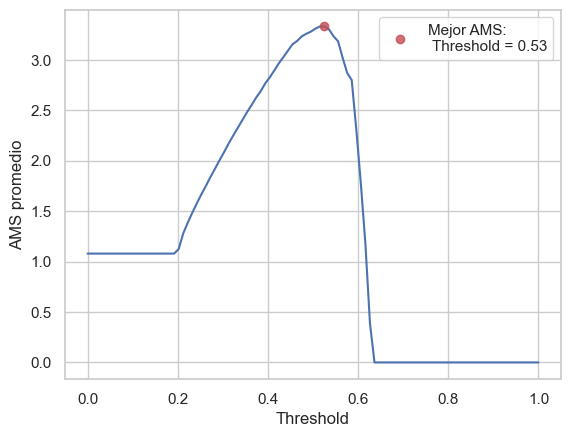

In [81]:
plt.plot(th, AMS_threshold_avg/5)
plt.plot(th[np.argmax(AMS_threshold_avg/5)], max(AMS_threshold_avg/5),
         'ro', label=f'Mejor AMS: \n Threshold = {th[np.argmax(AMS_threshold_avg/5)]:.2f}', alpha=0.8)
plt.xlabel('Threshold')
plt.ylabel('AMS promedio')

plt.legend()

print("Mejor threshold:", th[np.argmax(AMS_threshold_avg/5)], "Mejor AMS:", max(AMS_threshold_avg/5))

### Modelo 5 IterativeImputer + Transformación Logarítmica

In [80]:
#Mejor score XGB Bayesiano: 3.2397647944683863
#Mejores parámetros XGB Bayesiano: OrderedDict([('colsample_bytree', 0.4893204993147078), ('gamma', 0.0), ('learning_rate', 0.07447096918037242), ('max_depth', 69), ('min_child_weight', 18), ('n_estimators', 10), ('reg_alpha', 0.14077367912659144), ('reg_lambda', 3.0393252974841176), ('subsample', 0.7356246713487878)])

best_learning_rate = 0.07447096918037242
best_max_depth = 69
best_n_estimators = 10
best_min_child_weight = 18
best_subsample = 0.7356246713487878
best_colsample_bytree = 0.4893204993147078
best_gamma = 0.0
best_reg_alpha = 0.14077367912659144
best_reg_lambda = 3.0393252974841176



log_cols = [
    'DER_mass_MMC',
    'DER_mass_transverse_met_lep',
    'DER_mass_vis',
    'DER_pt_h',
    'DER_mass_jet_jet',
    'DER_pt_tot',
    'DER_sum_pt',
    'DER_pt_ratio_lep_tau',
    'PRI_met_sumet',
    'PRI_jet_leading_pt',
    'PRI_jet_subleading_pt',
    'PRI_jet_all_pt',
    'PRI_lep_pt',
    'PRI_tau_pt',
    'PRI_met'
]

df_train = pd.read_csv('training.csv')
X_train = df_train.drop(['EventId', 'Label', 'Weight'], axis=1)
y_train = (df_train['Label'] == 's').astype(int)

df_test = pd.read_csv('test.csv')
EventId_test = df_test['EventId']
X_test = df_test.drop(['EventId'], axis=1)

def safe_log1p(x):
    x = np.where(x <= -1, 0, x)
    return np.log1p(x)


preprocessing = ColumnTransformer([
    ('impute', IterativeImputer(missing_values=-999, max_iter=30, tol=1e-3, random_state=42), X_train.columns),
    ('log', FunctionTransformer(safe_log1p), log_cols)
], remainder='passthrough')

pipeline_5 = Pipeline([
    ('preprocesamiento', preprocessing),
    ('regressor', XGBClassifier(random_state=42,
                                #tree_method='hist',  # Método de árbol compatible con la GPU
                                #device='cuda',        # Configuración para usar la GPU
                                learning_rate=best_learning_rate,
                                max_depth=best_max_depth,
                                n_estimators=best_n_estimators,
                                min_child_weight=best_min_child_weight,
                                subsample=best_subsample,
                                colsample_bytree=best_colsample_bytree,
                                gamma=best_gamma,
                                reg_alpha=best_reg_alpha,
                                reg_lambda=best_reg_lambda))
])

pipeline_5.fit(X_train, y_train)
y_pred = pipeline_5.predict(X_test)

### Modelo 6 Random Forest (SimpleImputer)

In [28]:
# Mejor score RandomForest Bayesiano: 2.926976161201273
# Mejores parámetros RandomForest Bayesiano: OrderedDict([('max_depth', 34), ('max_features', 0.2546844052569046), ('min_samples_leaf', 5), ('min_samples_split', 8), ('n_estimators', 266)])

best_max_depth = 34
best_max_features = 0.2546844052569046
best_min_samples_leaf = 5
best_min_samples_split = 8
best_n_estimators = 266


df_train = pd.read_csv('training.csv')

X_train = df_train.drop(['EventId', 'Label', 'Weight'], axis=1)
y_train = (df_train['Label'] == 's').astype(int)


pipeline_6 = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=-999.00, strategy='most_frequent')),
    ('regressor', RandomForestClassifier(
        random_state=42,
        max_depth=best_max_depth,
        max_features=best_max_features,
        min_samples_leaf=best_min_samples_leaf,
        min_samples_split=best_min_samples_split,
        n_estimators=best_n_estimators
    
    ))
])


pipeline_6.fit(X_train, y_train)

df_test = pd.read_csv('test.csv')
EventId_test = df_test['EventId']
X_test = df_test.drop(['EventId'], axis=1)
y_pred = pipeline_6.predict(X_test)

## Comet

In [30]:
# Subir resultados del modelo correspondiente al Pipeline 1

scoring = {'AMS' : AMS_scorer,
           'acc': 'accuracy',
           'prec': 'precision',
           'rec': 'recall'}

pipeline_scores = cross_validate(pipeline, X_train, y_train, cv=stratified_indices, scoring=scoring)

API_KEY = 'FcR63ytMCgBIfqlz1nim1T9V7'
#Crear un experimento con tu API KEY
exp = Experiment(api_key=API_KEY,
                 project_name='taa_proyecto-1', # Nombre del proyecto donde se registran los experimentos
                 auto_param_logging=False)
exp.set_name('XGBClassifier_inicial') # Nombre de este experimento
exp.add_tags(['XGBClassifier']) # Tags

exp.log_parameters(pipeline.get_params())
exp.log_parameter("modelo","basico")

for k in range(pipeline_scores['test_AMS'].size):
    metrics_step = {
        'AMS' : pipeline_scores['test_AMS'][k],
        'Accuracy' : pipeline_scores['test_acc'][k],
        'Precision' : pipeline_scores['test_prec'][k],
        'Recall' : pipeline_scores['test_rec'][k]
    }
    exp.log_metrics(metrics_step,step=k)

exp.log_figure(figure_name="CV_AMS" ,figure=plt)
exp.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/home/valentin/OneDrive/FING/TAA/Proyecto_1' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/valentinb2001/taa-proyecto-1/3335243c18a74135a678ac26072af4fc

COMET WARNING: Refuse to upload empty figure, please call log_figure before calling show
COMET WARNING: Failing to save the matplotlib figure
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : XGBClassifier_inicial
COMET IN

<Figure size 640x480 with 0 Axes>

In [31]:
# Subir resultados del modelo correspondiente al Pipeline 3

scoring = {'AMS' : AMS_scorer,
           'acc': 'accuracy',
           'prec': 'precision',
           'rec': 'recall'}

pipeline_3_scores = cross_validate(pipeline_3, X_train, y_train, cv=stratified_indices, scoring=scoring)

API_KEY = 'FcR63ytMCgBIfqlz1nim1T9V7'
#Crear un experimento con tu API KEY
exp = Experiment(api_key=API_KEY,
                 project_name='taa_proyecto-1', # Nombre del proyecto donde se registran los experimentos
                 auto_param_logging=False)
exp.set_name('XGBClassifier_log_transform') # Nombre de este experimento
exp.add_tags(['XGBClassifier']) # Tags

exp.log_parameters(pipeline_3.get_params())
exp.log_parameter("modelo","basico")

for k in range(pipeline_3_scores['test_AMS'].size):
    metrics_step = {
        'AMS' : pipeline_3_scores['test_AMS'][k],
        'Accuracy' : pipeline_3_scores['test_acc'][k],
        'Precision' : pipeline_3_scores['test_prec'][k],
        'Recall' : pipeline_3_scores['test_rec'][k]
    }
    exp.log_metrics(metrics_step,step=k)

exp.log_figure(figure_name="CV_AMS" ,figure=plt)
exp.end()

/home/valentin/.local/lib/python3.10/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
/home/valentin/.local/lib/python3.10/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
/home/valentin/.local/lib/python3.10/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
/home/valentin/.local/lib/python3.10/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
/home/valentin/.local/lib/python3.10/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
/home/valentin/.local/lib/python3.10/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invali

<Figure size 640x480 with 0 Axes>

In [37]:
# Subir resultados del modelo correspondiente al Pipeline 4

scoring = {'AMS' : AMS_scorer,
           'acc': 'accuracy',
           'prec': 'precision',
           'rec': 'recall'}

pipeline_4_scores = cross_validate(pipeline_4, X_train, y_train, cv=stratified_indices, scoring=scoring)

API_KEY = 'FcR63ytMCgBIfqlz1nim1T9V7'
#Crear un experimento con tu API KEY
exp = Experiment(api_key=API_KEY,
                 project_name='taa_proyecto-1', # Nombre del proyecto donde se registran los experimentos
                 auto_param_logging=False)
exp.set_name('XGBClassifier_iterative') # Nombre de este experimento
exp.add_tags(['XGBClassifier']) # Tags

exp.log_parameters(pipeline_4.get_params())
exp.log_parameter("modelo","basico")

for k in range(pipeline_4_scores['test_AMS'].size):
    metrics_step = {
        'AMS' : pipeline_4_scores['test_AMS'][k],
        'Accuracy' : pipeline_4_scores['test_acc'][k],
        'Precision' : pipeline_4_scores['test_prec'][k],
        'Recall' : pipeline_4_scores['test_rec'][k]
    }
    exp.log_metrics(metrics_step,step=k)

exp.log_figure(figure_name="CV_AMS" ,figure=plt)
exp.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/home/valentin/OneDrive/FING/TAA/Proyecto_1' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/valentinb2001/taa-proyecto-1/0efbb6a783034fc7853f822efc8328e7

COMET WARNING: Refuse to upload empty figure, please call log_figure before calling show
COMET WARNING: Failing to save the matplotlib figure
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : XGBClassifier_iterative
COMET 

<Figure size 640x480 with 0 Axes>

In [29]:
# Subir resultados del modelo correspondiente al Pipeline 6

scoring = {'AMS' : AMS_scorer,
           'acc': 'accuracy',
           'prec': 'precision',
           'rec': 'recall'}

pipeline_6_scores = cross_validate(pipeline_6, X_train, y_train, cv=stratified_indices, scoring=scoring)

API_KEY = 'FcR63ytMCgBIfqlz1nim1T9V7'
#Crear un experimento con tu API KEY
exp = Experiment(api_key=API_KEY,
                 project_name='taa_proyecto-1', # Nombre del proyecto donde se registran los experimentos
                 auto_param_logging=False)
exp.set_name('RandomForest_inicial') # Nombre de este experimento
exp.add_tags(['Random Forest']) # Tags

exp.log_parameters(pipeline_6.get_params())
exp.log_parameter("modelo","basico")

for k in range(pipeline_6_scores['test_AMS'].size):
    metrics_step = {
        'AMS' : pipeline_6_scores['test_AMS'][k],
        'Accuracy' : pipeline_6_scores['test_acc'][k],
        'Precision' : pipeline_6_scores['test_prec'][k],
        'Recall' : pipeline_6_scores['test_rec'][k]
    }
    exp.log_metrics(metrics_step,step=k)

exp.log_figure(figure_name="CV_AMS" ,figure=plt)
exp.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, shap.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'c:\\Users\\Valentin\\OneDrive - Facultad de Ingeniería\\FING\\TAA\\Proyecto 1' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/valentinb2001/taa-proyecto-1/a8841f93f5f543469926d034287eb368

COMET WARNING: Refuse to upload empty figure, please call log_figure before calling show
COMET WARNING: Failing to save the matplotlib figure
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ------------------------------------------------------------------------

<Figure size 640x480 with 0 Axes>

## Submission

In [69]:
submission = pd.read_csv('random_submission.csv')
submission['Class'] = ['s' if pred == 1 else 'b' for pred in y_pred]
submission.to_csv('predicted_submission.csv', index=False)

In [70]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

api.competition_submit("predicted_submission.csv", "Modelo 5_v2", "higgs-boson")

100%|██████████| 8.81M/8.81M [00:03<00:00, 2.39MB/s]


Successfully submitted to Higgs Boson Machine Learning Challenge

## Shapley Values

In [88]:
# Aplica el preprocesamiento del pipeline
preprocessed_X_train = pipeline_4.named_steps['impute'].transform(X_train)

# Convertir a dataframe
feature_names = X_train.columns
preprocessed_X_train = pd.DataFrame(data=preprocessed_X_train, columns=feature_names)

In [89]:
explainer = shap.TreeExplainer(pipeline_4.named_steps['regressor'])
shap_values = explainer.shap_values(preprocessed_X_train)

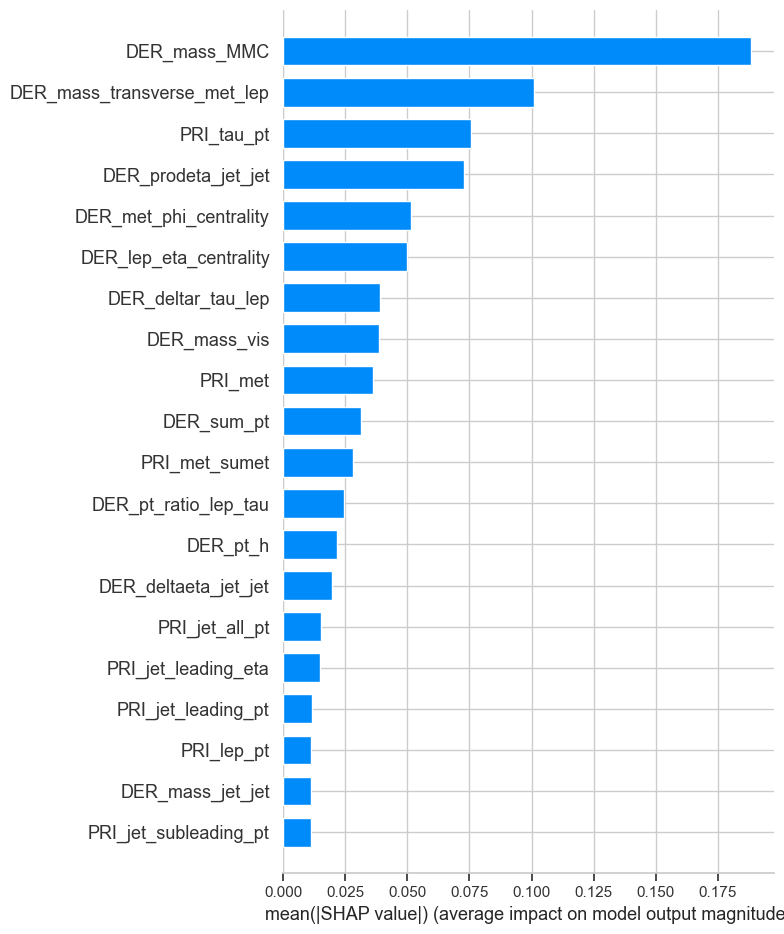

In [90]:
#Muestra la importancia de las características y los efectos de las mismas sobre el modelo
shap.summary_plot(shap_values, preprocessed_X_train, plot_type="bar")

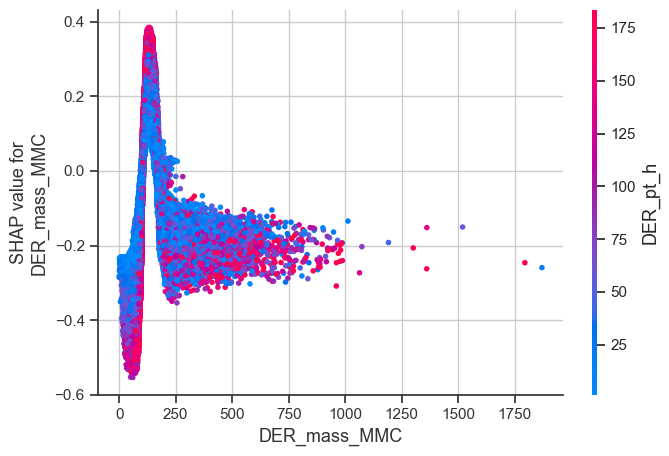

In [91]:
#Selecciona una característica para visualizar cómo afecta al output del modelo en combinación con otra característica
shap.dependence_plot("DER_mass_MMC", shap_values, preprocessed_X_train)

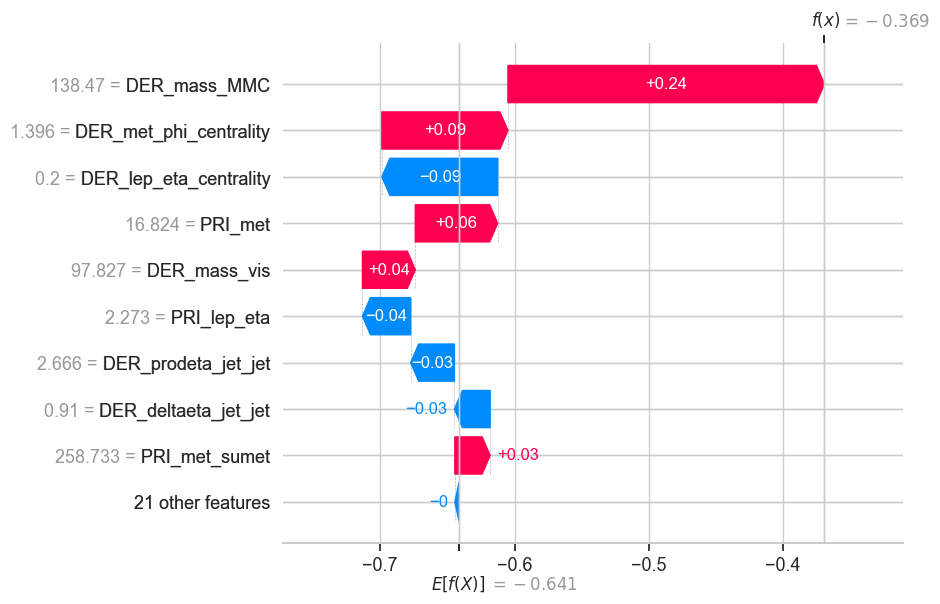

In [93]:
explanation = shap.Explanation(values=shap_values,
                               base_values=explainer.expected_value,
                               data=X_train,
                               feature_names=preprocessed_X_train.columns)

# Elegir un índice de ejemplo. Por ejemplo, el primer elemento.
shap.waterfall_plot(explanation[0])

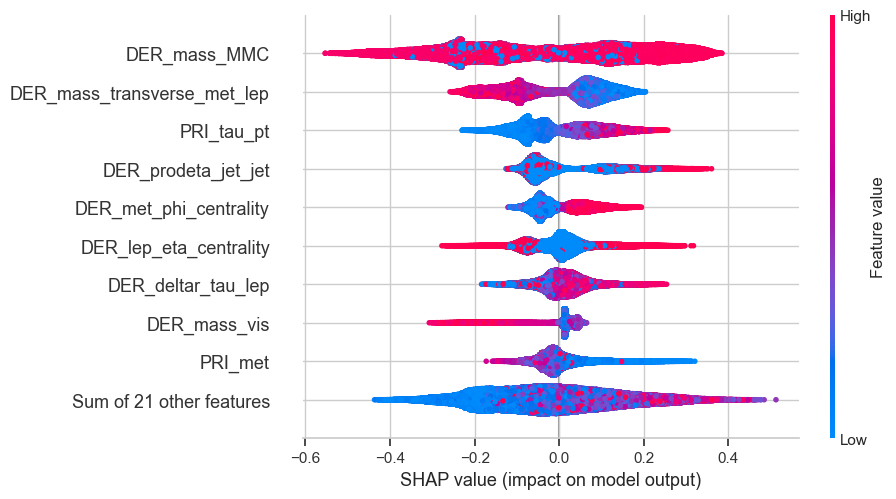

In [96]:
shap.plots.beeswarm(explanation)